Loading data from: /content/BCICIV_calib_ds1d.mat

--- Data Info ---
Shape of EEG: (59, 190473)
Sample rate: 100
Number of channels: 59
Channel names (first 5): [np.str_('AF3'), np.str_('AF4'), np.str_('F5'), np.str_('F3'), np.str_('F1')] ...
Number of events/markers loaded: 200
Event codes found: [-1  1]
Class labels: [np.str_('left'), np.str_('right')]
Number of classes: 2

--- Trial Extraction ---
Found 100 trials for class 'left' (code -1)
Found 100 trials for class 'right' (code 1)

Shape of trials[left]: (59, 200, 100)
Shape of trials[right]: (59, 200, 100)
Total trials extracted: 200

--- PSD Calculation (using Welch) ---
PSD calculated. Frequencies range from 0.00 Hz to 50.00 Hz.
Shape of PSD for 'left': (59, 65, 100)
Shape of PSD for 'right': (59, 65, 100)

--- Plotting PSD for Channel Groups ---
Plotting Frontal Lobe channels: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6']


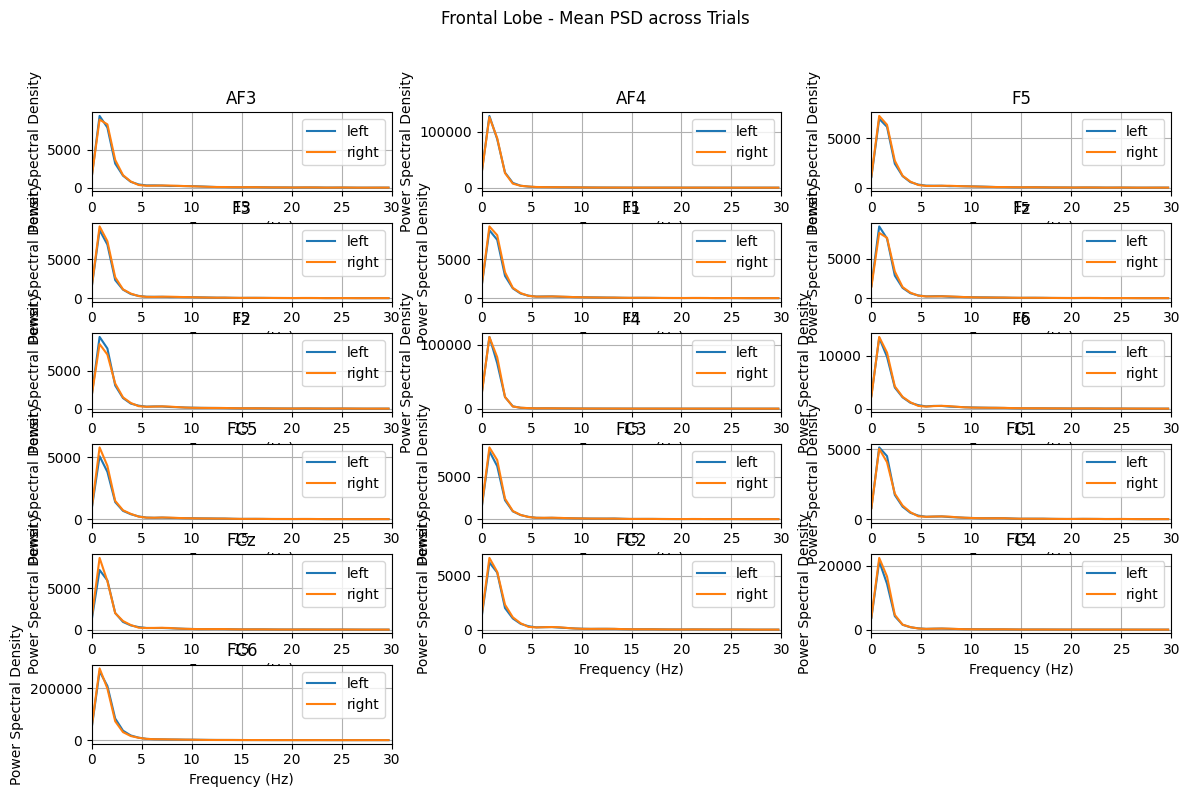

Plotting Central Lobe channels: ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6']


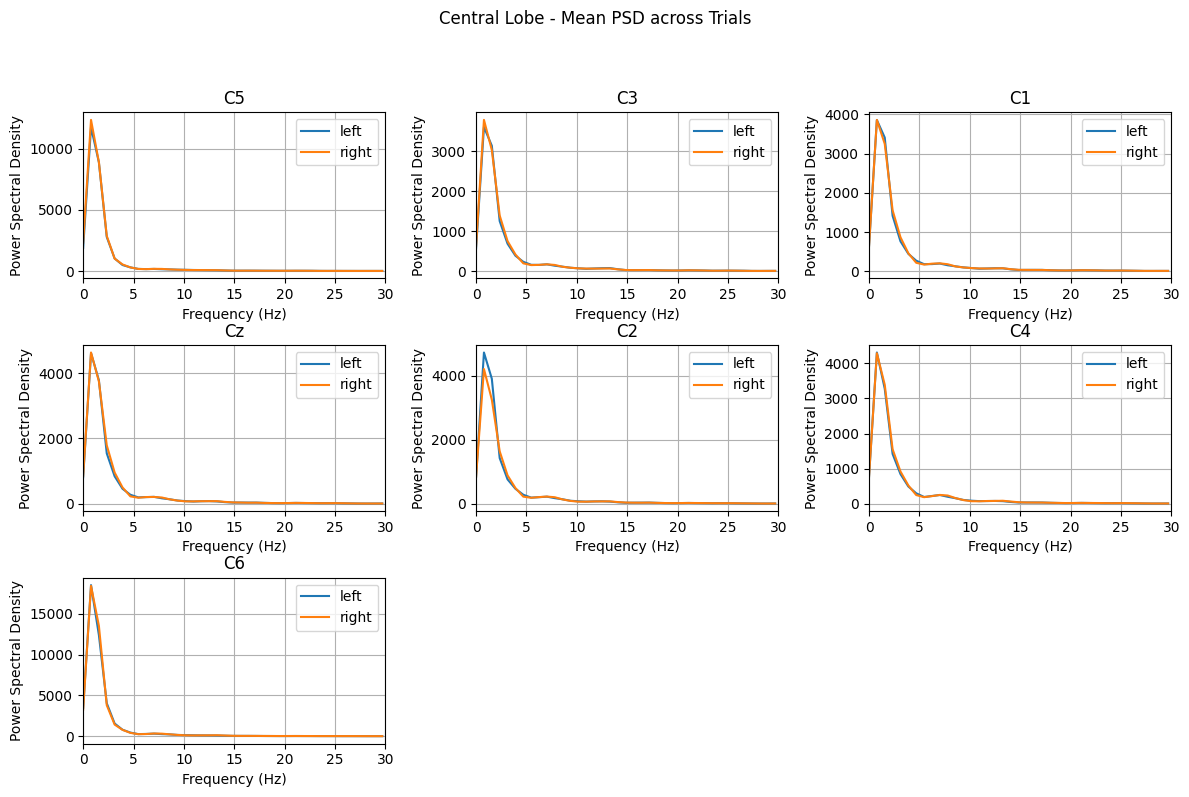

Plotting Parietal Lobe channels: ['CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6']


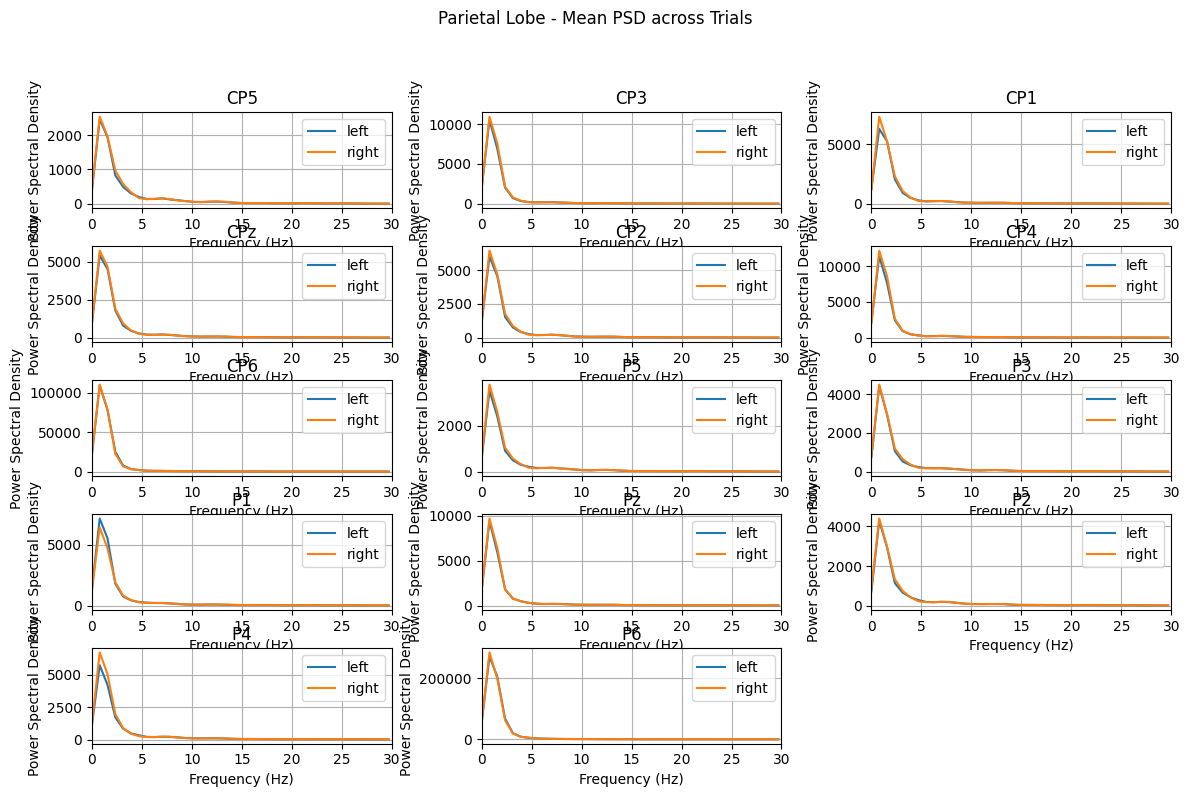

Plotting Temporal Lobe channels: ['T7', 'T8']


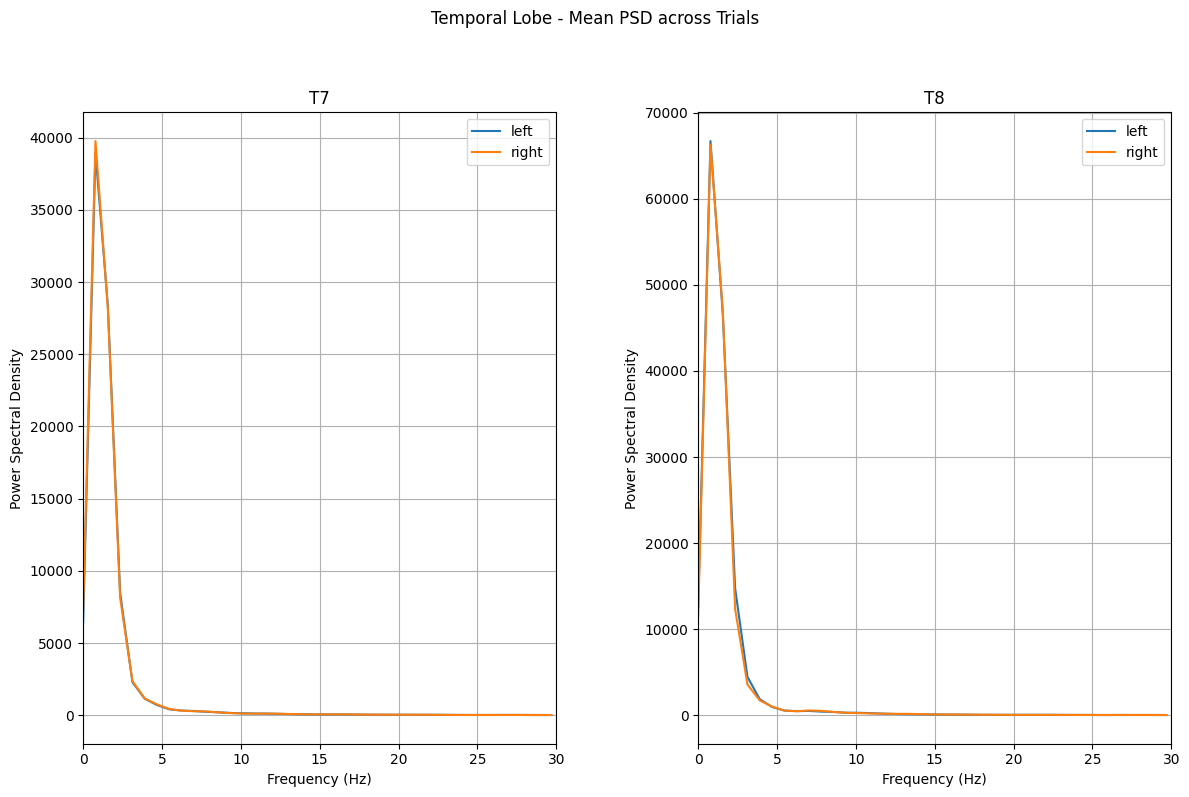

Plotting Occipital Lobe channels: ['O1', 'O2']


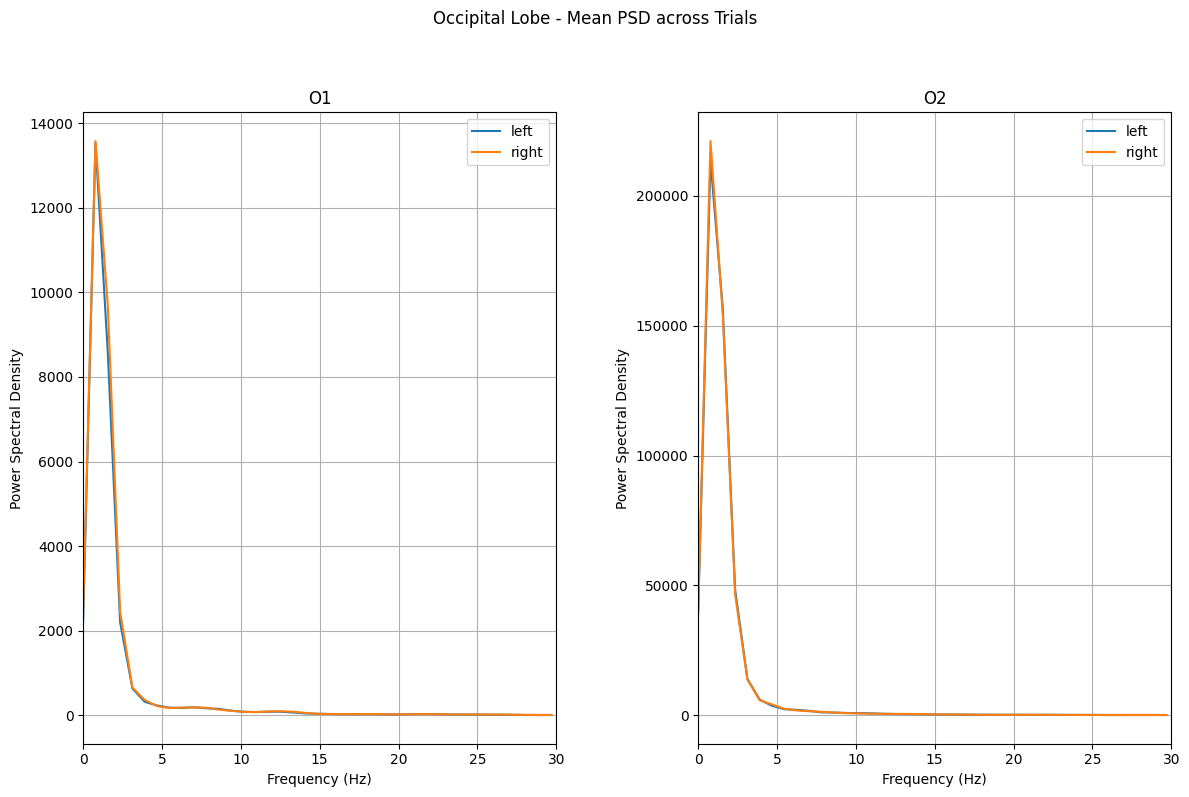


--- PSD for Specific Channels (C3, Cz, C4) ---
Shape of selected PSD array (classes, channels, freqs, trials): (2, 3, 65, 100)

--- PSD Values for Trial 0, Class 'left' ---

Channel: C3
PSD (65 frequency bins from 0.00Hz to 50.00Hz):
[2044.21354253 5418.91851396 3228.20560948  873.24083848  181.55527964] ...

Channel: Cz
PSD (65 frequency bins from 0.00Hz to 50.00Hz):
[1692.36002599 5142.36212691 4400.68865636 1288.85508945  257.6408291 ] ...

Channel: C4
PSD (65 frequency bins from 0.00Hz to 50.00Hz):
[1270.65235451 3747.6154608  2033.68353104  484.45798955  244.92402126] ...

--- Plotting Mean PSD for Selected Channels (C3, Cz, C4) ---


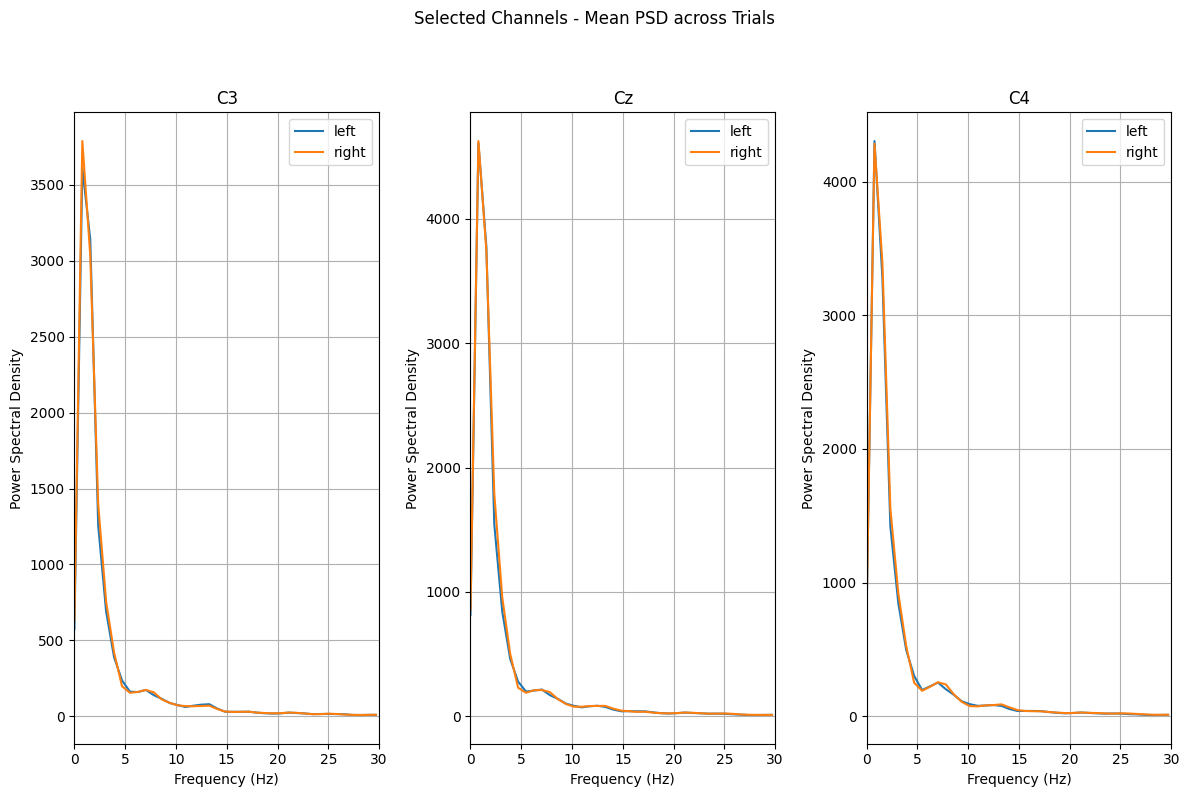


--- Script End ---


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import scipy.signal


mat_file_path = '/content/BCICIV_calib_ds1d.mat'

import os
if not os.path.exists(mat_file_path):
    raise FileNotFoundError(f"File not found at: {mat_file_path}")

print(f"Loading data from: {mat_file_path}")
try:
    m = scipy.io.loadmat(mat_file_path, struct_as_record=True)
except FileNotFoundError:
    print(f"Error: File not found at {mat_file_path}")
    print("Please ensure the .mat file is available at the specified path.")
    raise

sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples_total = EEG.shape

channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
event_onsets = m['mrk'][0][0][0].ravel()
event_codes = m['mrk'][0][0][1].ravel()


cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents_loaded = len(event_onsets)

print('\n--- Data Info ---')
print('Shape of EEG:', EEG.shape)
print('Sample rate:', sample_rate)
print('Number of channels:', nchannels)
print('Channel names (first 5):', channel_names[:5], '...')
print(f'Number of events/markers loaded: {nevents_loaded}')
print('Event codes found:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)

print('\n--- Trial Extraction ---')
trials = {}

win_start_s = 0.5
win_end_s = 2.5
win_start_samples = int(win_start_s * sample_rate)
win_end_samples = int(win_end_s * sample_rate)
win = np.arange(win_start_samples, win_end_samples)

nsamples_epoch = len(win)

total_trials_extracted = 0
for cl, code in zip(cl_lab, np.unique(event_codes)):
    cl_onsets = event_onsets[event_codes == code]
    n_cl_trials = len(cl_onsets)
    total_trials_extracted += n_cl_trials
    print(f"Found {n_cl_trials} trials for class '{cl}' (code {code})")

    trials[cl] = np.zeros((nchannels, nsamples_epoch, n_cl_trials))

    for i, onset in enumerate(cl_onsets):
        if onset + win_end_samples <= EEG.shape[1]:
             trials[cl][:,:,i] = EEG[:, win + onset]
        else:
             print(f"Warning: Trial {i} for class '{cl}' at onset {onset} exceeds data bounds. Skipping or handling needed.")

print('\nShape of trials[{}]: {}'.format(cl1, trials[cl1].shape))
print('Shape of trials[{}]: {}'.format(cl2, trials[cl2].shape))
print(f'Total trials extracted: {total_trials_extracted}')
nevents = total_trials_extracted

print('\n--- PSD Calculation (using Welch) ---')

def psd_welch(trials_data, fs, nperseg_val=128, noverlap_val=None):
    nchannels_func = trials_data.shape[0]
    nsamples_func = trials_data.shape[1]
    ntrials_func = trials_data.shape[2]

    nperseg_val = min(nsamples_func, nperseg_val)
    if noverlap_val is None:
        noverlap_val = nperseg_val // 2
    nfft_val = nperseg_val

    freqs_test, _ = scipy.signal.welch(trials_data[0, :, 0], fs=fs, nperseg=nperseg_val, noverlap=noverlap_val, nfft=nfft_val)
    n_freq_bins = len(freqs_test)

    trials_PSD = np.zeros((nchannels_func, n_freq_bins, ntrials_func))
    freqs = freqs_test

    for trial in range(ntrials_func):
        for ch in range(nchannels_func):
            f, Pxx = scipy.signal.welch(
                trials_data[ch, :, trial],
                fs=fs,
                nperseg=nperseg_val,
                noverlap=noverlap_val,
                nfft=nfft_val
            )

            trials_PSD[ch, :, trial] = Pxx.ravel()

    return trials_PSD, freqs

psd_r, freqs = psd_welch(trials[cl1], fs=sample_rate)
psd_f, freqs = psd_welch(trials[cl2], fs=sample_rate)

trials_PSD = {cl1: psd_r, cl2: psd_f}
print(f"PSD calculated. Frequencies range from {freqs[0]:.2f} Hz to {freqs[-1]:.2f} Hz.")
print(f"Shape of PSD for '{cl1}': {psd_r.shape}")
print(f"Shape of PSD for '{cl2}': {psd_f.shape}")

def plot_psd(trials_PSD_dict, freqs_array, chan_ind, chan_lab=None, max_freq=30, max_y=None, title_prefix=""):

    plt.figure(figsize=(12, 8))

    nchans_to_plot = len(chan_ind)
    ncols = min(3, nchans_to_plot)
    nrows = int(np.ceil(nchans_to_plot / ncols))

    freq_idx_max = np.where(freqs_array <= max_freq)[0][-1]

    for i, ch_idx in enumerate(chan_ind):
        plt.subplot(nrows, ncols, i + 1)

        for cl in trials_PSD_dict.keys():
            mean_psd = np.mean(trials_PSD_dict[cl][ch_idx, :, :], axis=1)
            plt.plot(freqs_array[:freq_idx_max+1], mean_psd[:freq_idx_max+1], label=cl)

        plt.xlim(0, max_freq)

        if max_y is not None:
            plt.ylim(0, max_y)

        plt.grid(True)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density')

        plot_title = f'Channel {ch_idx+1}'
        if chan_lab is not None and i < len(chan_lab):
            plot_title = chan_lab[i]
        plt.title(plot_title)

        plt.legend()


    plt.suptitle(f'{title_prefix}Mean PSD across Trials', y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.show()


print('\n--- Plotting PSD for Channel Groups ---')

frontal_channels = [ 'AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6',
                    'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6']

central_channels = ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6']

parietal_channels = ['CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
                     'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6']

temporal_channels = ['T7', 'T8']
occipital_channels = ['PO7', 'PO3', 'POz', 'PO4', 'PO8',
                      'O1', 'Oz', 'O2']


available_channels = set(channel_names)
lobes = {
    'Frontal Lobe': [ch for ch in frontal_channels if ch in available_channels],
    'Central Lobe': [ch for ch in central_channels if ch in available_channels],
    'Parietal Lobe': [ch for ch in parietal_channels if ch in available_channels],
    'Temporal Lobe': [ch for ch in temporal_channels if ch in available_channels],
    'Occipital Lobe': [ch for ch in occipital_channels if ch in available_channels]
}


for lobe, ch_names_in_lobe in lobes.items():
    if not ch_names_in_lobe:
        print(f"Skipping {lobe}: No matching channels found in data.")
        continue

    print(f"Plotting {lobe} channels: {ch_names_in_lobe}")
    indices = [channel_names.index(ch) for ch in ch_names_in_lobe]


    plot_psd(
        trials_PSD,
        freqs,
        indices,
        chan_lab=ch_names_in_lobe,
        max_freq=30,
        max_y=None,
        title_prefix=f'{lobe} - '
    )

print("\n--- PSD for Specific Channels (C3, Cz, C4) ---")


selected_channel_names = ['C3', 'Cz', 'C4']

available_selected_channels = [ch for ch in selected_channel_names if ch in available_channels]

if len(available_selected_channels) != len(selected_channel_names):
    print(f"Warning: Not all requested channels ({selected_channel_names}) found in data.")
    print(f"Using available channels: {available_selected_channels}")
    selected_channel_names = available_selected_channels

if selected_channel_names:

    channel_indices = [channel_names.index(ch) for ch in selected_channel_names]


    selected_psd_list = []
    for cl in trials_PSD:

        psd_data = trials_PSD[cl][channel_indices, :, :]
        selected_psd_list.append(psd_data)


    selected_psd_array = np.array(selected_psd_list)

    print("Shape of selected PSD array (classes, channels, freqs, trials):", selected_psd_array.shape)


    class_index_to_print = 0
    class_label_to_print = list(trials_PSD.keys())[class_index_to_print]
    trial_index_to_print = 0


    print(f"\n--- PSD Values for Trial {trial_index_to_print}, Class '{class_label_to_print}' ---")
    for idx, channel_name in enumerate(selected_channel_names):
        print(f"\nChannel: {channel_name}")

        psd_values = selected_psd_array[class_index_to_print, idx, :, trial_index_to_print]
        print(f"PSD ({len(freqs)} frequency bins from {freqs[0]:.2f}Hz to {freqs[-1]:.2f}Hz):")

        print(f"{psd_values[:5]} ...")

    print("\n--- Plotting Mean PSD for Selected Channels (C3, Cz, C4) ---")
    plot_psd(
        trials_PSD,
        freqs,
        channel_indices,
        chan_lab=selected_channel_names,
        max_freq=30,
        max_y=None,
        title_prefix='Selected Channels - '
    )

else:
    print("No channels selected or available to process in Cell 12.")

print("\n--- Script End ---")


--- Applying Bandpass Filter (8-15 Hz) ---
Bandpass filtering complete.
Shape of filtered trials 'left': (59, 200, 100)
Shape of filtered trials 'right': (59, 200, 100)

--- Calculating PSD on Filtered Data ---
PSD calculation on filtered data complete.

--- Plotting PSD for C3, Cz, C4 (Filtered Data) ---


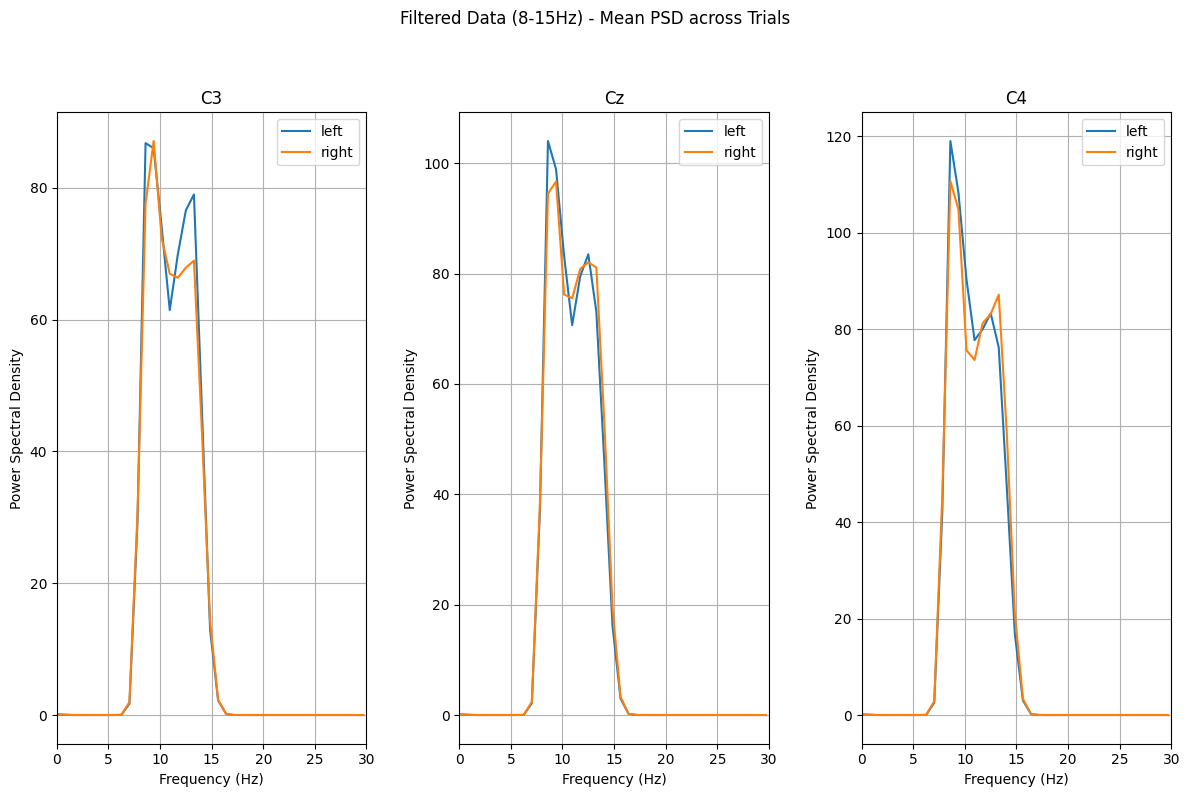


--- Plotting PSD for Lobes (Filtered Data) ---
Plotting Frontal Lobe (Filtered) channels: ['F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'AF3', 'AF4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6']


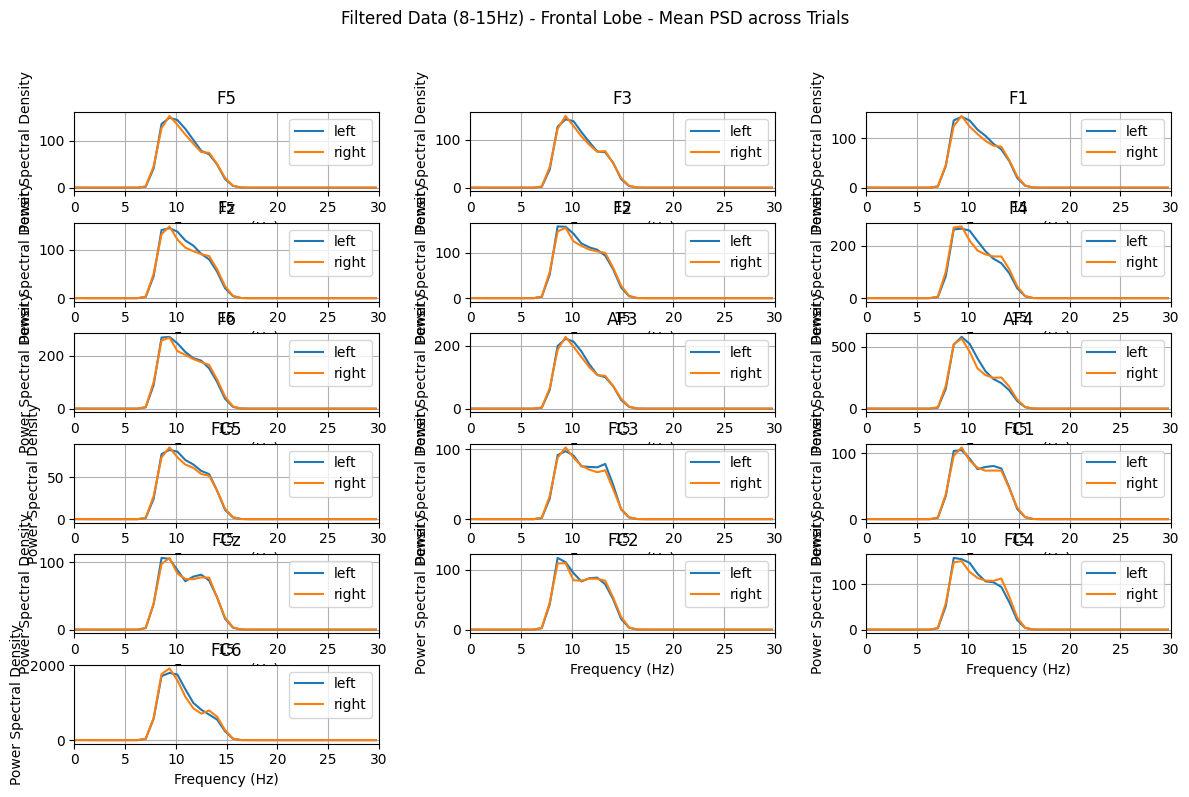

Plotting Central Lobe (Filtered) channels: ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6']


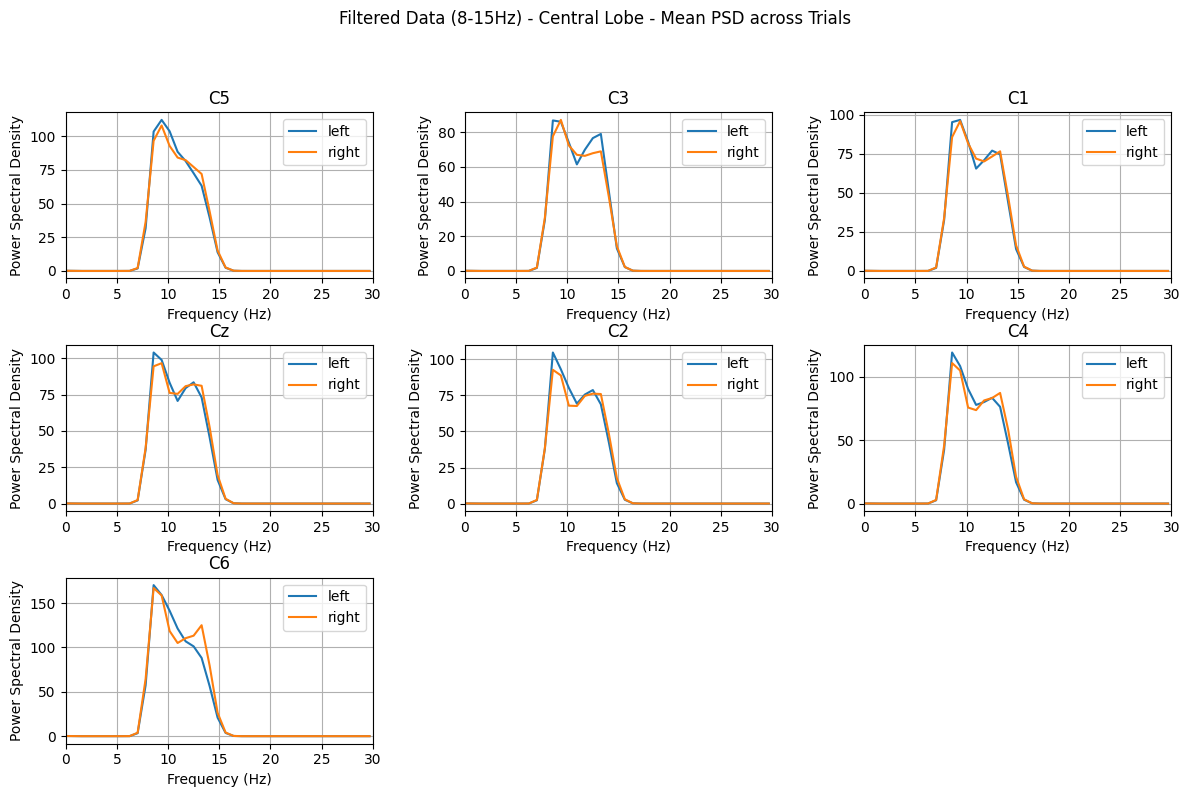

Plotting Parietal Lobe (Filtered) channels: ['CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6']


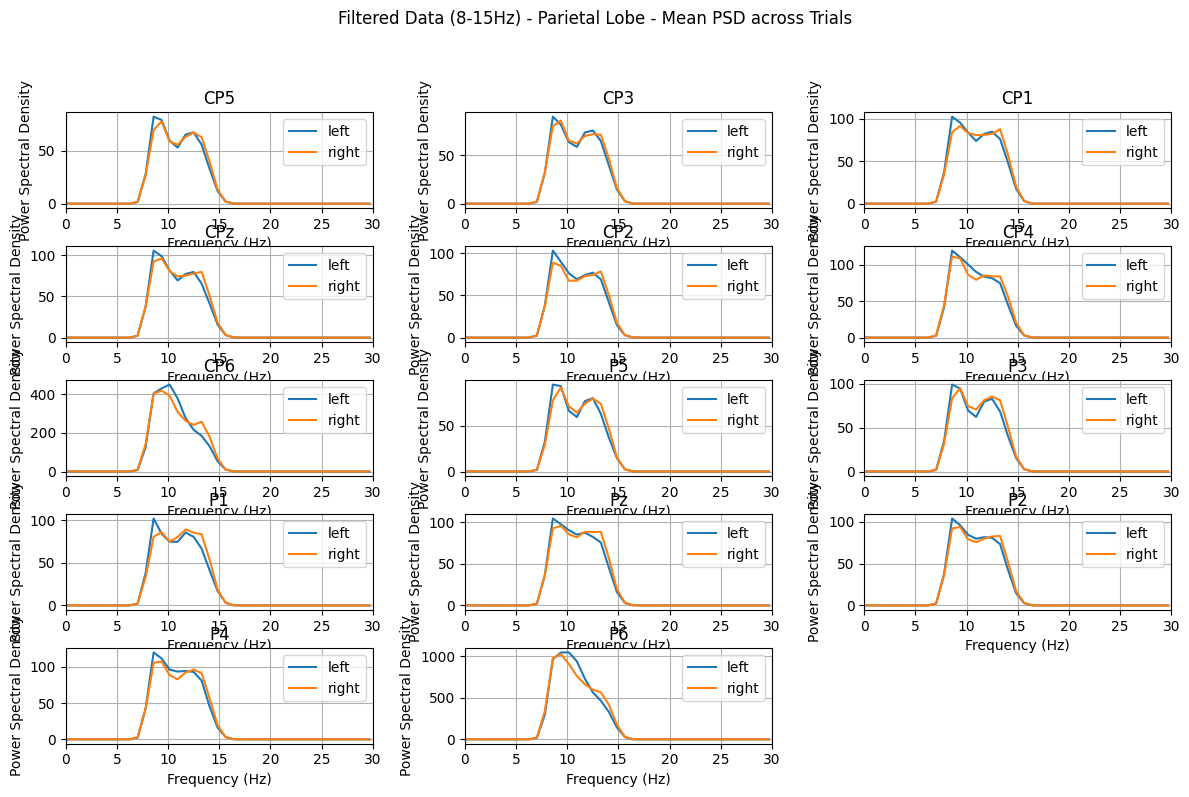

Plotting Temporal Lobe (Filtered) channels: ['T7', 'T8']


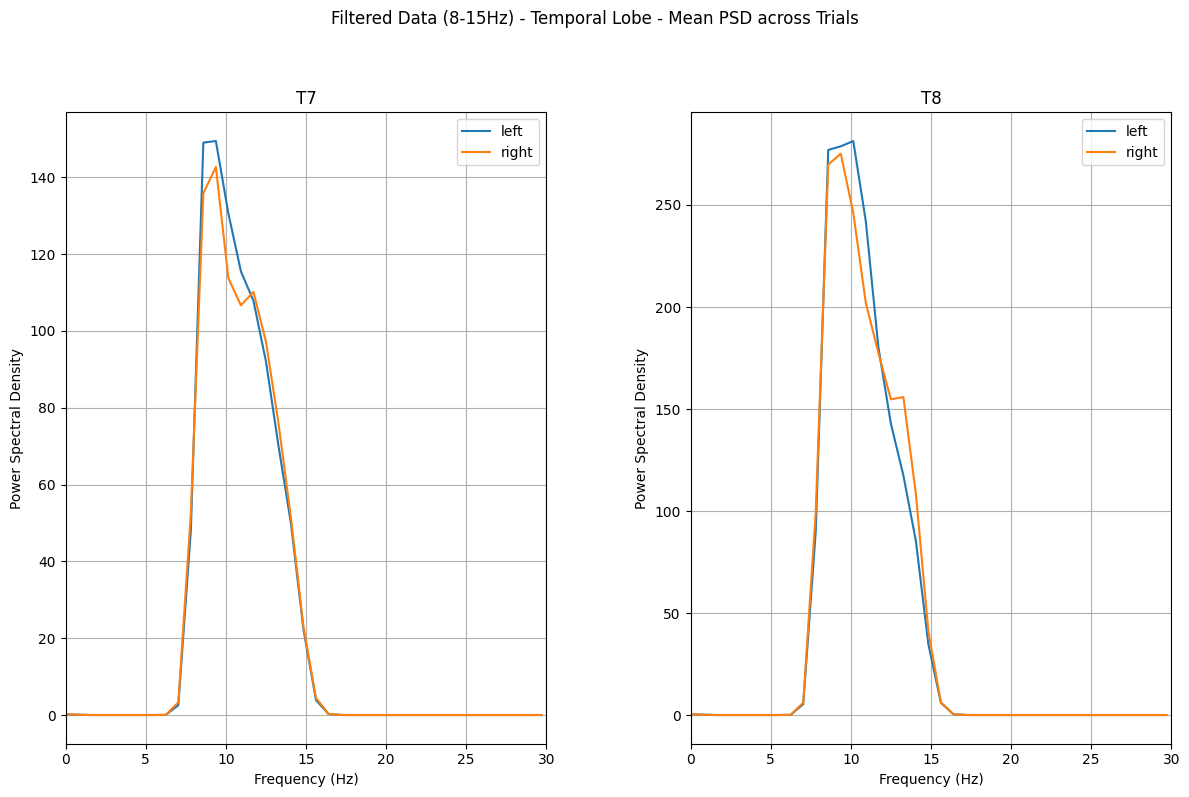

Plotting Occipital Lobe (Filtered) channels: ['O1', 'O2']


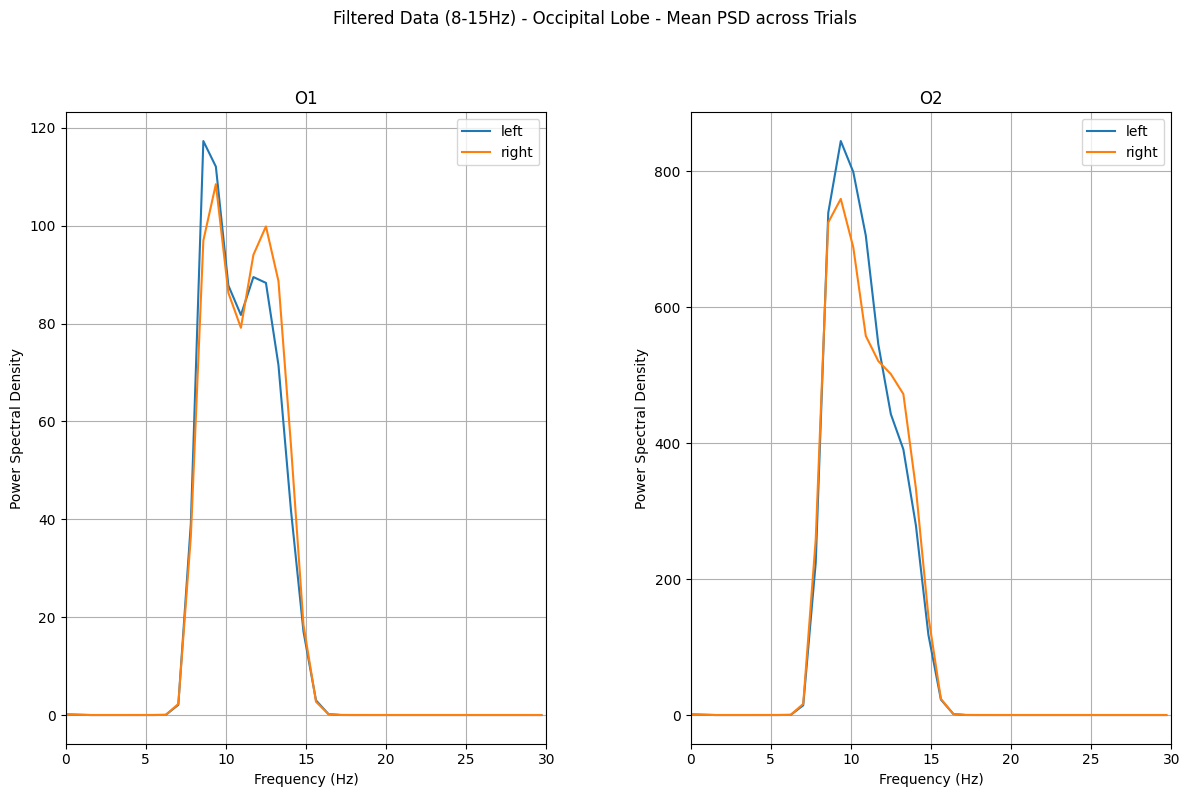

In [ ]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt



def bandpass(trials_data, lo, hi, fs):


    filter_order = 6
    nyquist = fs / 2.0
    low_norm = lo / nyquist
    high_norm = hi / nyquist


    try:

        b, a = scipy.signal.iirfilter(filter_order, [low_norm, high_norm],
                                      btype='band', ftype='butter', output='ba')
    except ValueError as e:
         print(f"Error designing filter: {e}")
         print(f"Check cutoff frequencies: lo={lo}, hi={hi}, Nyquist={nyquist}")
         raise


    nchannels_func, nsamples_func, ntrials_func = trials_data.shape

    trials_filt = np.zeros_like(trials_data)


    trials_filt = scipy.signal.filtfilt(b, a, trials_data, axis=1)


    return trials_filt


print("\n--- Applying Bandpass Filter (8-15 Hz) ---")
try:
    trials_filt = {
        cl1: bandpass(trials[cl1], 8, 15, sample_rate),
        cl2: bandpass(trials[cl2], 8, 15, sample_rate)
    }
    print("Bandpass filtering complete.")
    print(f"Shape of filtered trials '{cl1}': {trials_filt[cl1].shape}")
    print(f"Shape of filtered trials '{cl2}': {trials_filt[cl2].shape}")


    print("\n--- Calculating PSD on Filtered Data ---")
    psd_r_filt, freqs_filt = psd_welch(trials_filt[cl1], fs=sample_rate)
    psd_f_filt, freqs_filt = psd_welch(trials_filt[cl2], fs=sample_rate)
    trials_PSD_filt = {cl1: psd_r_filt, cl2: psd_f_filt}
    print("PSD calculation on filtered data complete.")


    print("\n--- Plotting PSD for C3, Cz, C4 (Filtered Data) ---")
    selected_channels_plot = ['C3', 'Cz', 'C4']
    # Check if channels exist
    available_selected_plot = [ch for ch in selected_channels_plot if ch in channel_names]
    if available_selected_plot:
        indices_plot = [channel_names.index(ch) for ch in available_selected_plot]

        plot_psd(
            trials_PSD_filt,
            freqs_filt,
            indices_plot,
            chan_lab=available_selected_plot,
            max_freq=30,
            max_y=None,
            title_prefix='Filtered Data (8-15Hz) - '
        )
    else:
        print("Channels C3, Cz, C4 not found in data.")


    print("\n--- Plotting PSD for Lobes (Filtered Data) ---")
    lobes_filt = {
        'Frontal Lobe': [ch for ch in ['F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'AF3', 'AF4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6'] if ch in channel_names],
        'Central Lobe': [ch for ch in ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6'] if ch in channel_names],
        'Parietal Lobe': [ch for ch in ['CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6'] if ch in channel_names],
        'Temporal Lobe': [ch for ch in ['T7', 'T8'] if ch in channel_names],
        'Occipital Lobe': [ch for ch in ['PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2'] if ch in channel_names]
    }

    for lobe, ch_names_in_lobe in lobes_filt.items():
        if not ch_names_in_lobe:
            print(f"Skipping {lobe} (Filtered): No matching channels found.")
            continue

        print(f"Plotting {lobe} (Filtered) channels: {ch_names_in_lobe}")
        indices = [channel_names.index(ch) for ch in ch_names_in_lobe]


        plot_psd(
            trials_PSD_filt,
            freqs_filt,
            indices,
            chan_lab=ch_names_in_lobe,
            max_freq=30,
            max_y=None,
            title_prefix=f'Filtered Data (8-15Hz) - {lobe} - '
        )


except NameError as e:
    print(f"Error: A required variable or function is not defined: {e}")
    print("Ensure the preceding notebook cells defining trials, sample_rate, psd_welch, plot_psd etc., have been executed.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


--- Applying CSP and Feature Extraction ---
Log-variance before CSP:


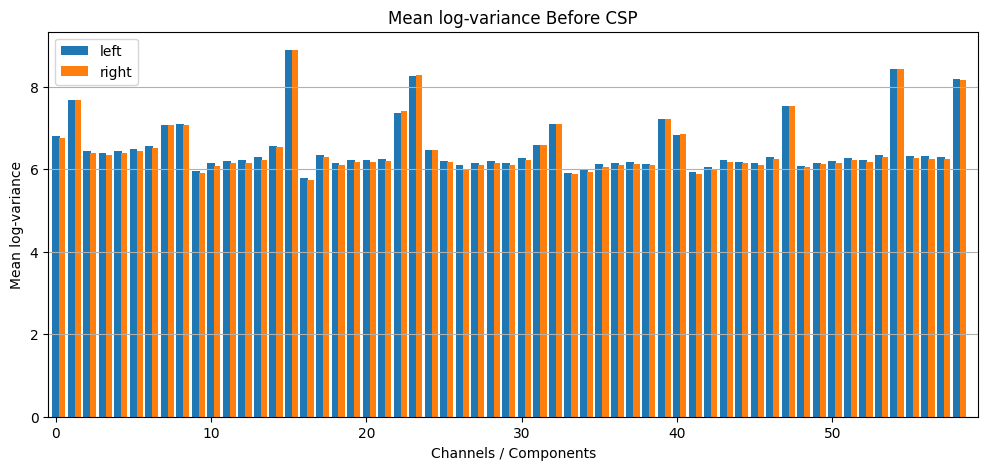

Calculating CSP filters...
Shape of CSP filters W: (59, 59)
Applying CSP filters...
Log-variance after CSP (on CSP components):


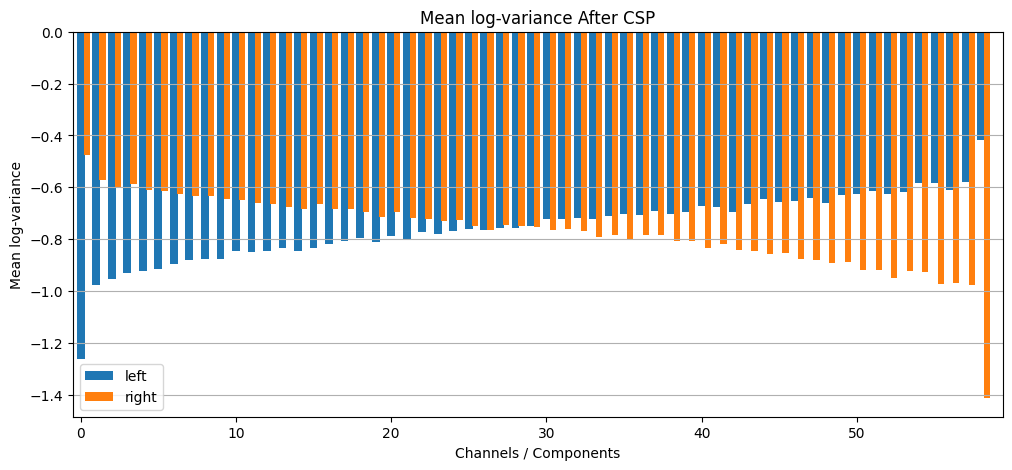

Calculating PSD of selected CSP components...
Plotting PSD for CSP components: [0, 29, 58]


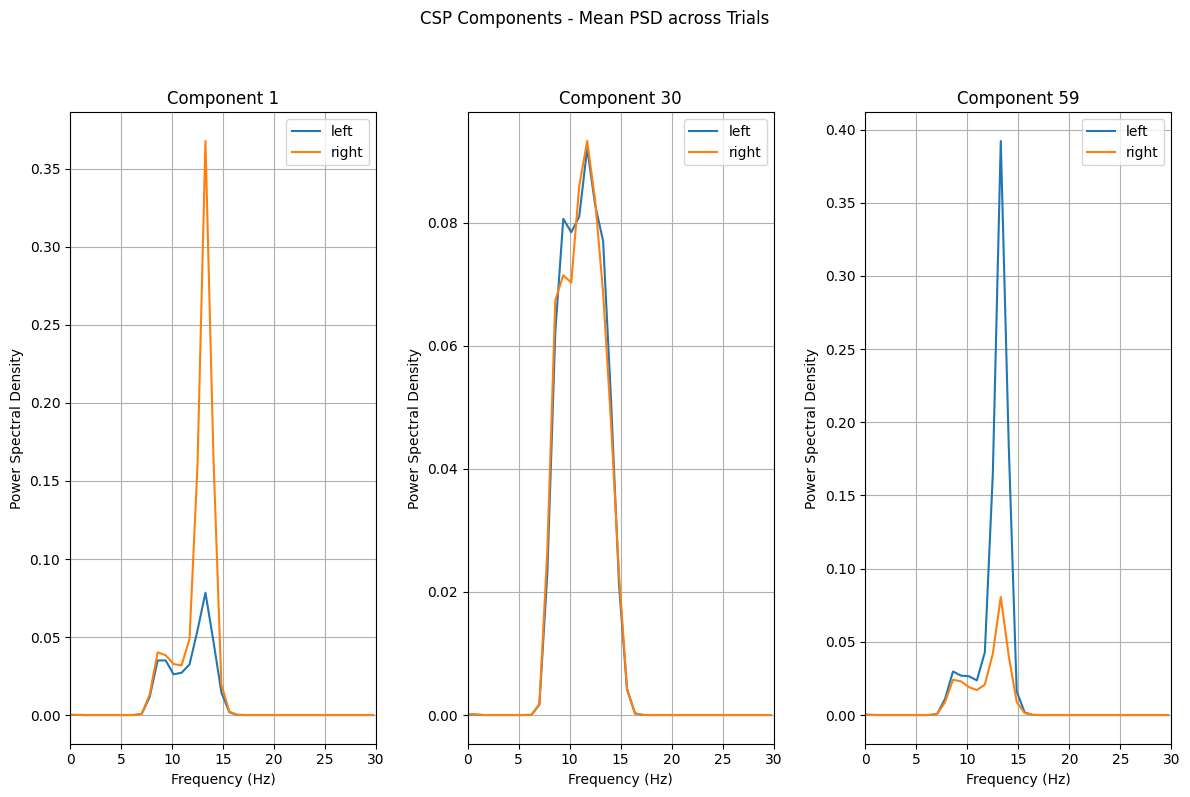

Plotting scatter plot of log-variance features (first vs last component)...


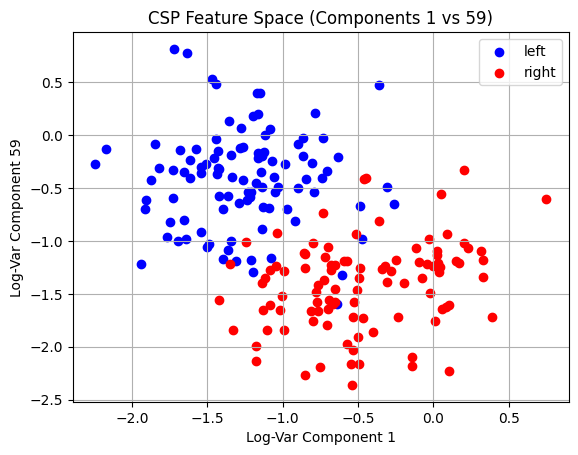


--- Preparing Data and Implementing LSTM ---
Using CSP component indices: [ 0  1  2 56 57 58]
Combined data shape (X): (200, 200, 6)
Combined labels shape (y): (200,)
X_train shape: (160, 200, 6)
X_test shape: (40, 200, 6)
y_train shape: (160,)
y_test shape: (40,)
Feature scaling complete.
y_train_cat shape: (160, 2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,554 (21.70 KB)

 Trainable params: 5,554 (21.70 KB)

 Non-trainable params: 0 (0.00 B)


--- Training LSTM Model ---
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.4500 - loss: 0.7065 - val_accuracy: 0.6250 - val_loss: 0.6792
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4688 - loss: 0.7004 - val_accuracy: 0.5938 - val_loss: 0.6804
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5219 - loss: 0.6912 - val_accuracy: 0.5938 - val_loss: 0.6815
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5240 - loss: 0.6912 - val_accuracy: 0.6250 - val_loss: 0.6822
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5406 - loss: 0.6862 - val_accuracy: 0.6562 - val_loss: 0.6825
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5802 - loss: 0.6820 - val_accuracy: 0.6250 - val_loss: 0.6817
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5646 - loss: 0.6940 - val_accuracy: 0.6250 - val_loss: 0.6815
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5646 - loss: 0.6695 - val_accu

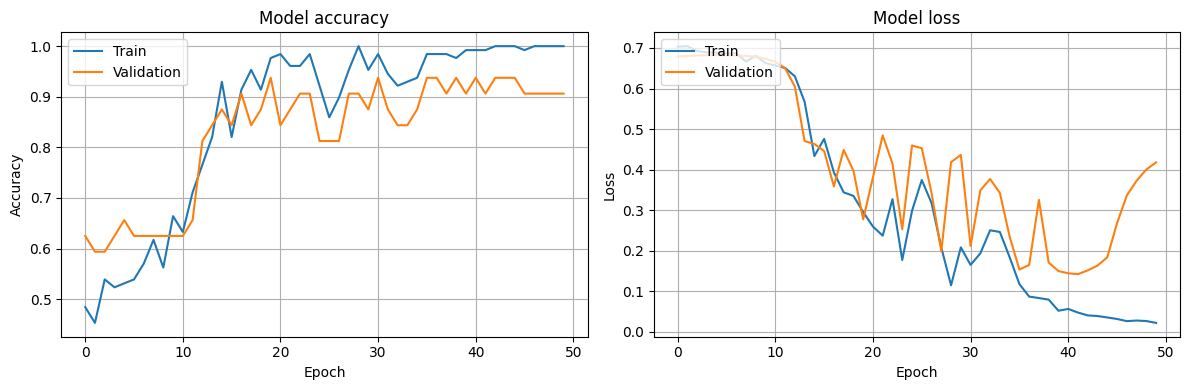


--- LSTM Implementation Finished ---


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

print("\n--- Applying CSP and Feature Extraction ---")

nsamples = nsamples_epoch


def logvar(trials):
    ''' Calculate the log-var of each channel/component. '''
    epsilon = 1e-10
    return np.log(np.var(trials, axis=1) + epsilon)

def cov(trials):
    ''' Calculate the covariance for each trial and return their average '''
    ntrials = trials.shape[2]
    nchannels_cov = trials.shape[0]
    nsamples_cov = trials.shape[1]

    covs = np.zeros((ntrials, nchannels_cov, nchannels_cov))

    for i in range(ntrials):
        trial_data = trials[:, :, i]
        trial_data_demeaned = trial_data - np.mean(trial_data, axis=1, keepdims=True)
        covs[i, :, :] = (trial_data_demeaned @ trial_data_demeaned.T) / nsamples_cov

    return np.mean(covs, axis=0)

def whitening(sigma):
    ''' Calculate a whitening matrix for covariance matrix sigma. '''
    try:
        U, l, _ = np.linalg.svd(sigma)
        epsilon = 1e-10
        return U @ np.diag((l + epsilon)** -0.5)
    except np.linalg.LinAlgError:
        print("SVD did not converge for whitening. Adding regularization.")
        reg_sigma = sigma + epsilon * np.identity(sigma.shape[0])
        U, l, _ = np.linalg.svd(reg_sigma)
        return U @ np.diag((l + epsilon)** -0.5)


def csp(trials_r, trials_f):
    ''' Calculate the CSP transformation matrix W. '''
    cov_r = cov(trials_r)
    cov_f = cov(trials_f)


    if np.any(np.isnan(cov_r)) or np.any(np.isinf(cov_r)) or \
       np.any(np.isnan(cov_f)) or np.any(np.isinf(cov_f)):
        raise ValueError("NaN or Inf found in covariance matrices. Check input data.")

    cov_sum = cov_r + cov_f
    if np.linalg.matrix_rank(cov_sum) < cov_sum.shape[0]:
         print("Warning: Composite covariance matrix is rank deficient.")

    P = whitening(cov_sum)

    if np.any(np.isnan(P)) or np.any(np.isinf(P)):
         raise ValueError("NaN or Inf found in whitening matrix P.")

    cov_r_white = P.T @ cov_r @ P
    cov_f_white = P.T @ cov_f @ P

    if np.any(np.isnan(cov_r_white)) or np.any(np.isinf(cov_r_white)) or \
       np.any(np.isnan(cov_f_white)) or np.any(np.isinf(cov_f_white)):
         raise ValueError("NaN or Inf found in whitened covariance matrices.")

    try:
        eigenvalues, B = np.linalg.eig(cov_f_white)
    except np.linalg.LinAlgError:
         raise ValueError("Eigenvalue decomposition failed in CSP.")


    ix = np.argsort(eigenvalues)[::-1]
    B = B[:, ix]


    W = P @ B
    return W

def apply_mix(W, trials):
    ''' Apply a mixing matrix (CSP filters) to each trial. '''
    nchannels_mix, nsamples_mix, ntrials_mix = trials.shape
    trials_csp = np.zeros((nchannels_mix, nsamples_mix, ntrials_mix))
    for i in range(ntrials_mix):
        trials_csp[:, :, i] = W.T @ trials[:, :, i]
    return trials_csp


print("Log-variance before CSP:")
trials_logvar_before = {cl1: logvar(trials_filt[cl1]), cl2: logvar(trials_filt[cl2])}
def plot_logvar(trials, title_suffix=""):
    plt.figure(figsize=(12, 5))
    ncomponents = trials[cl1].shape[0]
    x0 = np.arange(ncomponents)
    x1 = np.arange(ncomponents) + 0.4
    y0 = np.mean(trials[cl1], axis=1)
    y1 = np.mean(trials[cl2], axis=1)
    plt.bar(x0, y0, width=0.5, label=cl1)
    plt.bar(x1, y1, width=0.4, label=cl2)
    plt.xlim(-0.5, ncomponents - 0.5 + 0.4 + 0.5)
    plt.gca().yaxis.grid(True)
    plt.title(f'Mean log-variance {title_suffix}')
    plt.xlabel('Channels / Components')
    plt.ylabel('Mean log-variance')
    plt.legend()
    plt.show()

plot_logvar(trials_logvar_before, title_suffix="Before CSP")

print("Calculating CSP filters...")
W = csp(trials_filt[cl1], trials_filt[cl2])
print("Shape of CSP filters W:", W.shape)

print("Applying CSP filters...")
trials_csp = {cl1: apply_mix(W, trials_filt[cl1]),
              cl2: apply_mix(W, trials_filt[cl2])}


print("Log-variance after CSP (on CSP components):")
trials_logvar_csp = {cl1: logvar(trials_csp[cl1]),
                     cl2: logvar(trials_csp[cl2])}
plot_logvar(trials_logvar_csp, title_suffix="After CSP")

print("Calculating PSD of selected CSP components...")
try:
    psd_r_csp, freqs_csp = psd_welch(trials_csp[cl1], fs=sample_rate)
    psd_f_csp, _ = psd_welch(trials_csp[cl2], fs=sample_rate)
    trials_PSD_csp = {cl1: psd_r_csp, cl2: psd_f_csp}

    n_components = W.shape[1]
    middle_component_idx = n_components // 2
    component_indices_to_plot = [0, middle_component_idx, n_components - 1]
    component_labels = [f'Component {i+1}' for i in component_indices_to_plot]

    print(f"Plotting PSD for CSP components: {component_indices_to_plot}")
    plot_psd(trials_PSD_csp,
             freqs_csp,
             component_indices_to_plot,
             chan_lab=component_labels,
             max_freq=30,
             max_y=None,
             title_prefix="CSP Components - "
             )
except NameError:
    print("Error: psd_welch or plot_psd function not defined. Skipping PSD plotting of CSP components.")
except Exception as e:
    print(f"An error occurred during PSD calculation/plotting of CSP components: {e}")


def plot_scatter(logvar_features_cl1, logvar_features_cl2, component_indices=(0, -1)):
    ''' Plots a scatter plot for specified components '''
    idx1, idx2 = component_indices

    num_components = logvar_features_cl1.shape[0]
    if idx1 < 0: idx1 += num_components
    if idx2 < 0: idx2 += num_components

    plt.figure()
    plt.scatter(logvar_features_cl1[idx1, :], logvar_features_cl1[idx2, :], color='b', label=cl1)
    plt.scatter(logvar_features_cl2[idx1, :], logvar_features_cl2[idx2, :], color='r', label=cl2)
    plt.xlabel(f'Log-Var Component {idx1 + 1}')
    plt.ylabel(f'Log-Var Component {idx2 + 1}')
    plt.title(f'CSP Feature Space (Components {idx1+1} vs {idx2+1})')
    plt.legend()
    plt.grid(True)
    plt.show()

print("Plotting scatter plot of log-variance features (first vs last component)...")
plot_scatter(trials_logvar_csp[cl1], trials_logvar_csp[cl2], component_indices=(0, -1))


print("\n--- Preparing Data and Implementing LSTM ---")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


n_components_total = W.shape[1]

if 2 * m_components > n_components_total:
    print(f"Warning: Requested {2*m_components} components, but only {n_components_total} available. Using all components.")
    m_components = n_components_total // 2


csp_indices = np.concatenate((np.arange(m_components), np.arange(n_components_total - m_components, n_components_total))).astype(int)
print(f"Using CSP component indices: {csp_indices}")
n_selected_components = len(csp_indices)


csp_data_cl1 = trials_csp[cl1][csp_indices, :, :]
csp_data_cl2 = trials_csp[cl2][csp_indices, :, :]


X_cl1 = np.transpose(csp_data_cl1, (2, 1, 0))
X_cl2 = np.transpose(csp_data_cl2, (2, 1, 0))


X = np.vstack((X_cl1, X_cl2))

y_cl1 = np.zeros(X_cl1.shape[0])
y_cl2 = np.ones(X_cl2.shape[0])
y = np.hstack((y_cl1, y_cl2))

print(f"Combined data shape (X): {X.shape}")
print(f"Combined labels shape (y): {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

n_train_trials, n_timesteps, n_features = X_train.shape
n_test_trials = X_test.shape[0]

X_train_reshaped = X_train.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)

scaler = StandardScaler()
X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled_reshaped.reshape(n_train_trials, n_timesteps, n_features)
X_test_scaled = X_test_scaled_reshaped.reshape(n_test_trials, n_timesteps, n_features)

print("Feature scaling complete.")

n_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

print(f"y_train_cat shape: {y_train_cat.shape}")

model = Sequential()
model.add(LSTM(units=32,
               input_shape=(n_timesteps, n_features),
               return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=n_classes, activation='softmax'))

model.summary()


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- Training LSTM Model ---")
batch_size = 32
epochs = 50

history = model.fit(X_train_scaled, y_train_cat,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)


print("\n--- Evaluating LSTM Model ---")
loss, accuracy = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

print("\n--- LSTM Implementation Finished ---")